In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

import warnings
warnings.filterwarnings('ignore')

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

#機器學習
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV


# 設定 data_path
dir_data = './data/'

In [10]:
#安裝geopandas有許多坑，很容易error，可以參考 https://zhuanlan.zhihu.com/p/137628480，文中第3個方法
#地理資料相關
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries

from shapely import geos, geometry
from shapely.geometry import shape,LineString,Point,Polygon

import fiona
from fiona.crs import from_epsg,from_string

#繪圖相關
import folium
from folium import IFrame

#顏色相關
import seaborn as sns
import branca

In [47]:
import osmnx as ox
import networkx as nx

In [17]:
# GIS編碼轉換
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf
# 中文顯示
def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]
heading3 = """<h3>{}</h3>""".format

In [41]:
f_path = os.path.join(dir_data, 'GIS/捷運_1100406/MRT_1100406.shp')
print('Path of read in data: %s' % (f_path))

gdf_mrt = gpd.read_file(f_path,encoding='utf-8')

Path of read in data: ./data/GIS/捷運_1100406/MRT_1100406.shp


In [358]:
gdf_mrt['MRTCODE'].unique()

array(['中和新蘆線', '文湖線', '板南線', '淡水信義線', '機場捷運', '松山新店線', None, '貓空纜車',
       '新北投線', '綠線', '紅線', '橘線', '環狀線', '三鶯線', '小碧潭線'], dtype=object)

In [311]:
MRT=pd.read_excel(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\捷運站經緯度.xlsx')
MRT_sub=MRT[MRT['station_name_tw'].isin(['景美','大坪林','七張','新店區公所','新店','小碧潭','南勢角','景安','永安市場'])].reset_index(drop=True)

In [312]:
MRT_sub

,station_code,construction_id,station_name_tw,station_name_en,line_code,line_name,address,lat,lon,color
0,G01,G1,新店,Xindian,G,松山新店線,新北市新店區北宜路一段2號,24.957855,121.537584,#008659
1,G02,G2,新店區公所,Xindian District Office,G,松山新店線,新北市新店區北新路一段295號,24.967393,121.541310,#008659
2,G03,G3,七張,Qizhang,G,松山新店線,新北市新店區北新路二段150號,24.975169,121.542942,#008659
3,G03A,G1A,小碧潭,Xiaobitan,G,松山新店線,新北市新店區中央路151號4樓,24.971907,121.530339,#008659
4,G04,G4,大坪林,Dapinglin,G,松山新店線,新北市新店區北新路三段190號,24.982899,121.541352,#008659
5,G05,G5,景美,Jingmei,G,松山新店線,台北市文山區羅斯福路六段393號,24.992128,121.540604,#008659
6,O01,O19,南勢角,Nanshijiao,O,中和新蘆線,新北市中和區捷運路6號,24.990045,121.509237,#f8b61c
7,O02,O18,景安,Jingan,O,中和新蘆線,新北市中和區景平路486號,24.993905,121.505113,#f8b61c
8,O03,O17,永安市場,Yongan Market,O,中和新蘆線,新北市中和區中和路388號,25.002876,121.511231,#f8b61c
9,Y07,Y6,大坪林,Dapinglin,Y,環狀線,新北市新店區北新路三段190號,24.982899,121.541352,#ffdb00


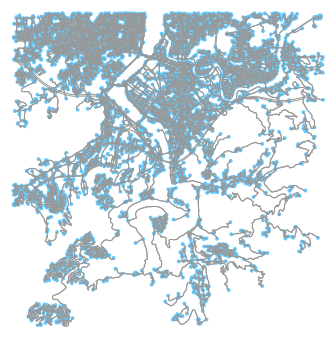

1


In [56]:
#drive_service
site_lat = 24.956544
site_lon = 121.536432
G = ox.graph_from_point((site_lat, site_lon), dist=6000, network_type='drive_service')
ox.plot_graph(G)

In [256]:
gdf1,gdf2=ox.graph_to_gdfs(G)

G = ox.project_graph(G) # 投影
meters_per_minute = 30 * 1000 / 60 # 每小時30公里
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

trip_times = [1, 2, 4] #分鐘
# 給定顏色
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)


for i in range(MRT_sub.shape[0]):
    if i == 0:
        center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0_base = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1_base = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2_base = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
        
    else:
        center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0 = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1 = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2 = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
    
        sub_convex0_base = gpd.overlay(sub_convex0_base,sub_convex0,  how='union')
        sub_convex1_base = gpd.overlay(sub_convex1_base,sub_convex1,  how='union')
        sub_convex2_base = gpd.overlay(sub_convex2_base,sub_convex2,  how='union')
        
        sub_convex0_base['df']=0
        sub_convex0_base = sub_convex0_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex1_base['df']=1
        sub_convex1_base = sub_convex1_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex2_base['df']=2
        sub_convex2_base = sub_convex2_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
    
    print(2)

sub_convex0_base = gpd.GeoDataFrame(sub_convex0_base,crs = gdf1.crs)
sub_convex1_base = gpd.GeoDataFrame(sub_convex1_base,crs = gdf1.crs)
sub_convex2_base = gpd.GeoDataFrame(sub_convex2_base,crs = gdf1.crs)

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


In [313]:
f_path = os.path.join(dir_data, 'Real estate valuation data set.xlsx')
print('Path of read in data: %s' % (f_path))

df = pd.read_excel(f_path)

Path of read in data: ./data/Real estate valuation data set.xlsx


In [315]:
print(np.array(df.columns))
df.columns = ['No','Trans_Date','Age','D2MRT','n_convenience_stores','lat','lon','Y']
print(np.array(df.columns))

['No' 'X1 transaction date' 'X2 house age'
 'X3 distance to the nearest MRT station'
 'X4 number of convenience stores' 'X5 latitude' 'X6 longitude'
 'Y house price of unit area']
['No' 'Trans_Date' 'Age' 'D2MRT' 'n_convenience_stores' 'lat' 'lon' 'Y']


In [316]:
# 查看資料大小
print('Data shape: ', df.shape)

Data shape:  (414, 8)


In [317]:
# 查看資料內容
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
        
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))        
        
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
    
columns_type(df)
object_check(df)
print('\n')
print('Data na_check')
na_check(df)

類型 :  int64 

  個數 :  2 

   ['No', 'n_convenience_stores'] 

-----------------------------------------------

類型 :  float64 

  個數 :  6 

   ['Trans_Date', 'Age', 'D2MRT', 'lat', 'lon', 'Y'] 

-----------------------------------------------



,Column,Unique Count




Data na_check


,Missing Ratio


In [318]:
df['Year'] = df['Trans_Date'].astype('int')
df['Month'] = (((df['Trans_Date'] - df['Trans_Date'].astype('int')) * 12) + 1).astype('int')

In [335]:
df_train = df.copy()

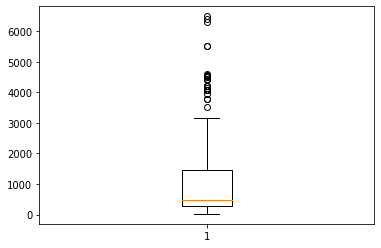

In [342]:
plt.boxplot(df_train['D2MRT'])
plt.show()

In [350]:
df_train['D2MRT'][df_train['D2MRT']>2000]=2000

In [351]:
#想畫顏色的變數
variable='D2MRT'

#設定色階
df_train['id']=df_train.index
color=df_train.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8
print(p)

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
#colorscale = branca.colormap.linear.YlGnBu_09.scale(low, 0.4)
colorscale

250.0


In [352]:
df_train['color'] = color.apply(lambda x : colorscale(x))

In [353]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]

In [354]:
# 設定圖例
colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
colormap.caption ='Number'
#colormap.caption ='Member Penetration Rates'
#colormap.caption ='Average Consumption'

In [361]:
# 設定地圖一開始顯示的中心與大小
mm=folium.Map(location=台北車站,zoom_start=12)

#捷運路線
folium.GeoJson(
        gdf_mrt.loc[gdf_mrt['MRTCODE'].isin(['松山新店線','小碧潭線','中和新蘆線']),:],
        
        name='捷運路線').add_to(mm)

#捷運站
if 1==1:
    #MRT_cluster = MarkerCluster(name='MRT').add_to(mm)
    fg1=folium.FeatureGroup(name='MRT', show=True)
    for i in range(MRT.shape[0]):
        if MRT.line_code[i] in ['G','O']:
            iframe = IFrame(html=heading3(utf2asc(MRT.station_name_tw[i])),width=250,height=50)
            popup = folium.Popup(iframe)
            folium.Marker(location=[MRT.lat[i], MRT.lon[i]],
                           popup=popup,
                           icon=folium.Icon(icon='train',
                                            color='black',
                                            icon_color=MRT.color[i],
                                            prefix='fa')).add_to(fg1)
    mm.add_child(fg1)

#距離遠近
if 1==1:
    fg2=folium.FeatureGroup(name='遠', show=True)
    fg3=folium.FeatureGroup(name='中', show=True)
    fg4=folium.FeatureGroup(name='近', show=True)

    folium.Choropleth(geo_data=sub_convex0_base,fill_color=iso_colors[0],fill_opacity=0.15).add_to(fg2)
    mm.add_child(fg2)
    folium.Choropleth(geo_data=sub_convex1_base,fill_color=iso_colors[1],fill_opacity=0.175).add_to(fg3)
    mm.add_child(fg3)
    folium.Choropleth(geo_data=sub_convex2_base,fill_color=iso_colors[2],fill_opacity=0.2).add_to(fg4)
    mm.add_child(fg4)

#道路交叉口
if 1==0:
    fg5=folium.FeatureGroup(name='道路交叉口', show=True)
    for idx,data in gdf1.iterrows():
        if idx==center_node:
            folium.Circle([data.geometry.y,data.geometry.x],radius=100,color='yellow',fill=True).add_to(fg5)
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
        else:
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
    mm.add_child(fg5)    

#房屋位置
if 1==1:
    num=df_train.shape[0]
    lat=np.array(df_train["lat"][0:num])
    lon=np.array(df_train["lon"][0:num])
    data1=[[lat[i],lon[i],1] for i in range(num)]
    fg1=folium.FeatureGroup(name='房屋(點)', show=True)
    for i in range(num):
        folium.Circle(location=[data1[i][0],data1[i][1]],
        color=df_train['color'][i], # Circle 顏色
        radius=25, # Circle 寬度
        fill=True, # 填滿中間區域
        fill_opacity=0.7 # 設定透明度
        ).add_to(fg1)
    mm.add_child(fg1)    
    
    
colormap.add_to(mm)

folium.LayerControl().add_to(mm)

In [362]:
mm